## 0.Package Import

In [21]:
import os
import re
import chardet
import zipfile

import pandas as pd
import numpy as np #for arrays

from bs4 import BeautifulSoup
# comp-linguistics
import spacy
from spacy.lang.en.examples import sentences 
from spacy import displacy
import en_core_web_sm #python -m spacy download en_core_web_sm

import gensim
import nltk
from nltk.text import Text

from sklearn.feature_extraction.text import CountVectorizer

import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import seaborn as sns

In [15]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flori\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [22]:
nlp = spacy.load("en_core_web_sm")

## 1.Preprocess source folder 

In [24]:
nlp = spacy.load("en_core_web_sm")
# Increase the max length
nlp.max_length = 25000000 

In [ ]:
folder_path = 'D:/NOW/sources'

def detect_encoding(file_path):
    with open(file_path, 'rb') as file:
        raw_data = file.read(50000)  # Read the first 50000 bytes to guess the encoding
        result = chardet.detect(raw_data)
        return result['encoding']

all_data = []

for filename in os.listdir(folder_path):
    if filename.startswith('sources') and filename.endswith('.txt'):
        file_path = os.path.join(folder_path, filename)
        # Print the current file being processed
        print(f"Processing file: {filename}")

        # Detect and use the encoding
        file_encoding = detect_encoding(file_path)
        try:
            with open(file_path, 'r', encoding=file_encoding) as file:
                for line in file:
                    columns = line.strip().split('\t')
                    all_data.append(columns)
        except UnicodeDecodeError:
            # Fallback to 'ISO-8859-1' if the initial attempt fails
            with open(file_path, 'r', encoding='ISO-8859-1') as file:
                for line in file:
                    columns = line.strip().split('\t')
                    all_data.append(columns)

column_names = ['textID', '#words', 'date', 'country', 'website', 'url', 'title']
combined_source = pd.DataFrame(all_data, columns=column_names)

# Create a new column for the year extracted from the 'date' column
combined_source['year'] = combined_source['date'].str.split('-').str[0]

# Create a directory to store the output files
output_dir = 'output_files'
os.makedirs(output_dir, exist_ok=True)

# Group by year and save each group
for year, group in combined_source.groupby('year'):
    #excel_file = os.path.join(output_dir, f'sources_{year}.xlsx')
    csv_file = os.path.join(output_dir, f'sources_{year}.csv')
    
    # Saving to Excel - one sheet per file
    #group.to_excel(excel_file, index=False)
    
    # Saving to CSV
    group.to_csv(csv_file, index=False)

    print(f"Saved data for year {year} to CSV")

## 2.Preprocess text folder 

In [ ]:
folder_path = 'D:/NOW/text'
all_data = []

def detect_encoding(byte_stream):
    result = chardet.detect(byte_stream)
    return result['encoding'] if result['encoding'] is not None else 'utf-8'

def clean_text(text):
    # Replace problematic characters and patterns
    text = text.replace('\t', ' ').replace('\n', ' ').replace('@@', '')
    return text.strip()

def process_text_file(file_content, file_encoding):
    # Revised regular expression pattern
    pattern = r"@@(\d+)(.*?)(?=@@\d+|$)"
    for record in re.finditer(pattern, file_content, re.DOTALL):
        text_id, text = record.groups()
        text_cleaned = clean_text(text)
        if 'telehealth' in text_cleaned.lower() or 'telemedicine' in text_cleaned.lower():
            all_data.append([text_id, text_cleaned])
            print(f"Processed text ID: {text_id}")  # Debugging line

for foldername in os.listdir(folder_path):
    if foldername.startswith('text-') and foldername.endswith('.zip'):
        zip_path = os.path.join(folder_path, foldername)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            for fileinfo in zip_ref.infolist():
                if fileinfo.filename.endswith('.txt'):
                    print(f"Processing file: {fileinfo.filename} in {foldername}")
                    with zip_ref.open(fileinfo) as file:
                        byte_stream = file.read(50000)
                        file.seek(0)
                        file_encoding = detect_encoding(byte_stream)
                        file_content = file.read().decode(file_encoding, errors='ignore')
                        process_text_file(file_content, file_encoding)

column_names = ['textID', 'text']
combined_df = pd.DataFrame(all_data, columns=column_names)

output_csv_path = 'combined_text_data.csv'
combined_df.to_csv(output_csv_path, index=False)
print(f"Data saved to '{output_csv_path}', containing {len(combined_df)} records.")


## 3.Clean corpus and combine it with "source" data by "textID"

In [ ]:
def clean_html(text):
    # Parse HTML content
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_special_characters(text):
    # Remove special characters and extra spaces
    text = re.sub(r'[@\-]', '', text)  # remove dashes and @ symbols
    text = re.sub(r'\s+', ' ', text)   # replace multiple spaces with a single space
    return text.strip()

# Clean the text column
combined_df['text'] = combined_df['text'].apply(clean_html).apply(remove_special_characters)

In [ ]:
# Convert 'textID' to string in both DataFrames
combined_df['textID'] = combined_df['textID'].astype(str).str.strip()
combined_source['textID'] = combined_source['textID'].astype(str).str.strip()

# Merge the DataFrames
merged_df = pd.merge(combined_df, combined_source, on='textID', how='left')

In [ ]:
# Check for completely duplicate rows
duplicate_rows = merged_df[merged_df.duplicated(keep=False)]
#print(duplicate_rows)
merged_df.drop_duplicates(inplace=True)

In [12]:
#merged_df.to_csv('final_df.csv',index=False) 
merged_df=pd.read_csv("D:/NOW/output_files/final_df.csv")

In [6]:
# Perform more feature tockenization on partial text
# function from lucem_illud/lucem_illud/processing.py
def word_tokenize(word_list, model=nlp, MAX_LEN=15000000):
    
    tokenized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 
    # removed RAM intensive operations and increase max text size

    model.max_length = MAX_LEN
    doc = model(word_list, disable=["parser", "tagger", "ner"])
    
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

word_tokenize(merged_df['text'][3])

c:\Users\flori\AppData\Local\Programs\Python\Python39\lib\site-packages\spacy\pipeline\lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


['Market',
 'Segment',
 'by',
 'Regions',
 'this',
 'report',
 'splits',
 'Global',
 'into',
 'several',
 'key',
 'Regions',
 'with',
 'production',
 'consumption',
 'revenue',
 'market',
 'share',
 'and',
 'growth',
 'rate',
 'of',
 'Healthcare',
 'IT',
 'Solutions',
 'in',
 'these',
 'regions',
 'from',
 '2011',
 'to',
 '2021',
 'forecast',
 'like',
 'North',
 'America',
 'Europe',
 'China',
 'Japan',
 'Southeast',
 'Asia',
 'India',
 'Split',
 'by',
 'product',
 'type',
 'with',
 'production',
 'revenue',
 'price',
 'market',
 'share',
 'and',
 'growth',
 'rate',
 'of',
 'each',
 'type',
 'can',
 'be',
 'divided',
 'into',
 'HER',
 'PACS',
 'Interoperability',
 'Healthcare',
 'Analytics',
 'Telemedicine',
 'CRM',
 'Split',
 'by',
 'application',
 'this',
 'report',
 'focuses',
 'on',
 'consumption',
 'market',
 'share',
 'and',
 'growth',
 'rate',
 'of',
 'Healthcare',
 'IT',
 'Solutions',
 'in',
 'each',
 'application',
 'can',
 'be',
 'divided',
 'into',
 'Contact',
 'Profile',
 '

## 4.EDA/Exam the text more closely 


In [6]:
merged_df.columns

Index(['textID', 'text', '#words', 'date', 'country', 'website', 'url',
       'title', 'year'],
      dtype='object')

In [4]:
merged_df.shape

(25594, 9)

In [10]:
merged_df.head()

,textID,text,#words,date,country,website,url,title,year
0,16223152,is growing rapidly and is expected to grow at ...,333.0,17-01-04,AU,NewsMake,http://www.newsmaker.com.au/news/210232/digita...,Digital Pathology Market Key Players Q2 Soluti...,17.0
1,16233365,"a community owned , not for profit organisatio...",458.0,17-01-04,AU,PRWir,http://prwire.com.au/pr/64982/make-2017-your-y...,Make 2017 your year to get a little bit of hel...,17.0
2,16336940,Clinicians call for government to improve broa...,539.0,17-01-10,AU,CIO Australia,http://www.cio.com.au/article/612580/clinician...,Clinicians call for government to improve broa...,17.0
3,16457068,"Market Segment by Regions , this report splits...",336.0,17-01-18,AU,NewsMake,http://www.newsmaker.com.au/news/224423/global...,"Global Healthcare IT Solutions Market Growth, ...",17.0
4,16497238,Market Study on Expected Growth for Critical C...,719.0,17-01-20,AU,NewsMake,http://www.newsmaker.com.au/news/227591/market...,Market Study on Expected Growth for Critical C...,17.0


### 4.1 Text Length Distribution 

<Axes: >

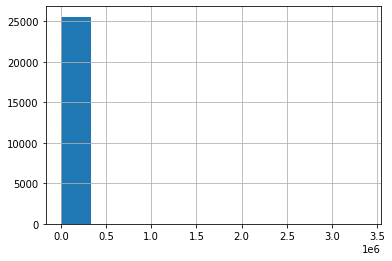

In [34]:
merged_df['text'].str.len().hist()

<Axes: >

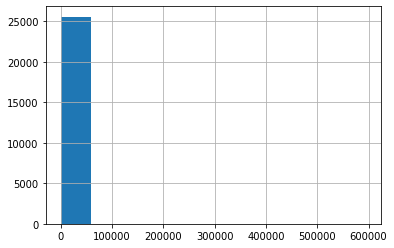

In [29]:
# number of words appearing in each text at word level
merged_df['text'].str.split().map(lambda x:len(x)).hist()

<Axes: >

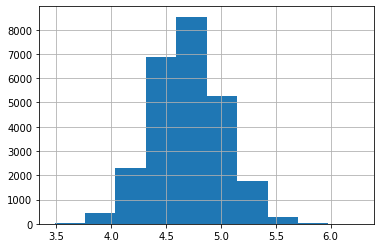

In [32]:
#  average word length in each sentence
merged_df['text'].str.split().apply(lambda x: [len(i)for i in x]).map(lambda x: np.mean(x)).hist()

In [7]:
merged_df['country'].value_counts()

US    14367
CA     2206
IN     2080
AU     1668
SG      856
GB      762
NG      597
NZ      497
PH      451
ZA      441
IE      434
PK      285
MY      274
KE      168
BD       99
??       91
LK       82
HK       72
GH       40
JM       40
TZ       34
?         5
          1
Name: country, dtype: int64

In [9]:
merged_df['website'].value_counts()

Business Insider              537
Forbes                        449
The Motley Fool               435
YAHOO!Finance                 419
politico.com                  235
                             ... 
Variety on MSN.com              1
The Topeka Capital-Journal      1
United States Army              1
PopSugar on MSN.com             1
ProPublica                      1
Name: website, Length: 3020, dtype: int64

In [15]:
# Ensure 'year' is of type string for categorical plotting
merged_df['year'] = merged_df['year'].astype(str)

# Filter out rows where 'country' is NaN or does not contain only alphabets
filtered_df = merged_df[pd.notnull(merged_df['country']) & merged_df['country'].str.isalpha()]

# Group the data by 'country' and 'year' and count the occurrences
country_year_df = filtered_df.groupby(['country', 'year']).size().reset_index(name='counts')

# Pivot the DataFrame to have countries as columns, years as rows
pivot_df = country_year_df.pivot(index='year', columns='country', values='counts').fillna(0)

# Sort the DataFrame by index (year) if necessary
pivot_df.sort_index(inplace=True)


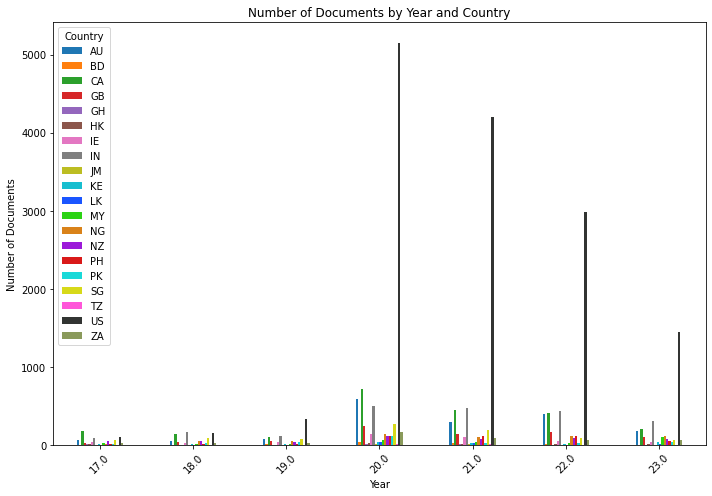

In [23]:
# Define a colormap/ a list of colors
# colormap = get_cmap('tab20')  # Colormap with 20 distinct colors
# colors = [colormap(i) for i in range(len(pivot_df.columns))]
custom_colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
    '#1a55FF', '#2BD314', '#D98219', '#9C19D9', '#D91919',
    '#19D9D8', '#D7D919', '#FF56D9', '#323432', '#8A9A5B'
]

# Use 'custom_colors' in the plotting command
pivot_df.plot(kind='bar', stacked=False, figsize=(10, 7), color=custom_colors)

# Add some labels and title
plt.xlabel('Year')
plt.ylabel('Number of Documents')
plt.title('Number of Documents by Year and Country')

# Rotate the x-axis labels so they are readable
plt.xticks(rotation=45)

# Display the legend
plt.legend(title='Country')

# Show the plot
plt.tight_layout()  # Adjust the layout to make room for the x-axis labels
plt.show()


* We can see that in general, there is an indication of growth in telehealth documentation from all countries in the most recent years depicted, especially in the US, which could be attributed to factors like the COVID-19 pandemic accelerating the adoption of telehealth services. Certain countries like India and US stand out for having higher overall activity levels, possibly due to more developed telehealth services or have had events that led to more documentation and research. Interestingly, US and some other countries shows decreasing telehealth documents trend after 2020.

### 4.2 NLTK - word tokenize and collocations

In [17]:
def word_tokenize(word_list):
    tokenized = []
    # pass word list through language model.
    doc = nlp(word_list)
    for token in doc:
        if not token.is_punct and len(token.text.strip()) > 0:
            tokenized.append(token.text)
    return tokenized

In [25]:
# Global - to store all tokens
all_tokens = []
# Function to process a chunk of data
def process_chunk(text_series):
    global all_tokens  # Declare the use of the global variable
    all_text = ' '.join(text_series.astype(str))
    tokens = word_tokenize(all_text)
    all_tokens.extend(tokens)  # Append tokens from this chunk to the global token list
    text_object = Text(tokens)
    return text_object

# Number of rows per chunk
chunk_size = 100  # Adjust 

# List to store Text objects
text_objects = []

# Process DataFrame in chunks
for start in range(0, len(merged_df), chunk_size):
    end = start + chunk_size
    chunk = merged_df['text'][start:end]
    text_obj = process_chunk(chunk)
    text_objects.append(text_obj)

# text_objects is a list of NLTK Text objects, each representing a chunk of data
text_objects[0].collocations() # find frequently occurring pairs of words (bigrams)
text_objects[0].concordance('telehealth') #search for a word within the text and display its immediate context

In [ ]:
# 2. count words
countedWords = wordCounter(text_objects[0])
countedWords.sort_values('count', ascending=False, inplace=True)
countedWords[:100]

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(range(len(countedWords)), countedWords['count'])
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

Observed by plotting the data on a log-log graph, with the axes being log (rank order) and log (frequency) resulting in a linear relationship.This shows that likelihood of a word occurring is inversely proportional to its rank, aligns with the [Zipf's Law](https://en.wikipedia.org/wiki/Zipf%27s_law), and suggests that the most frequent word will occur approximately twice as often as the second most frequent word, three times as often as the third most frequent word, etc. 

### 4.3 sklearn n-gram

In [37]:
def plot_selected_top_ngrams_barchart(text, n=2, topcount=20):
    new = text.str.split()
    new = new.values.tolist()
    corpus = [word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(stop_words='english', ngram_range=(n, n)).fit(corpus)
        global bag_of_words
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0)
        global words_freq
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
        return words_freq

    top_n_bigrams = _get_top_ngram(corpus, n)[:topcount]
    x, y = map(list, zip(*top_n_bigrams))
    sns.barplot(x=y, y=x)

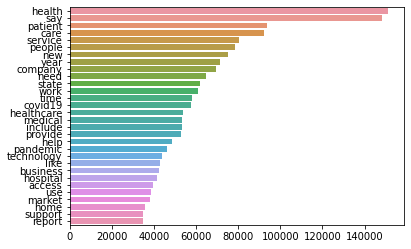

In [19]:
# plot_top_ngrams_barchart(test_ser, n=1, topcount = 30)
plot_selected_top_ngrams_barchart(merged_df['normalized_tokens'], n=1, topcount = 30)

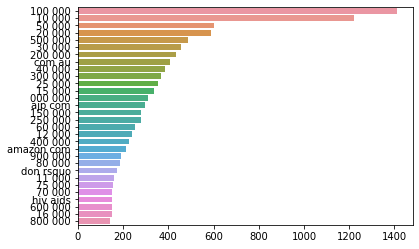

In [38]:
#plot_selected_top_ngrams_barchart(merged_df['normalized_tokens'], n=2, topcount = 30)
plot_selected_top_ngrams_barchart(my_doc, n=2, topcount = 30)

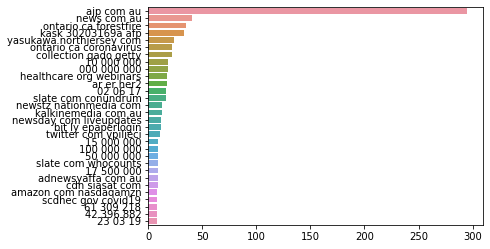

In [39]:
#plot_selected_top_ngrams_barchart(merged_df['normalized_tokens'], n=3, topcount = 30)
plot_selected_top_ngrams_barchart(my_doc, n=3, topcount = 30)

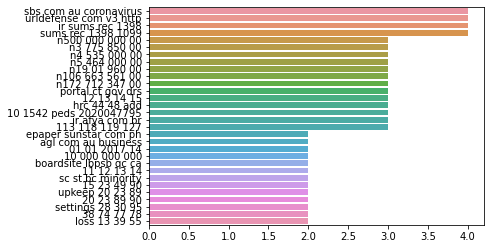

In [40]:
#plot_selected_top_ngrams_barchart(merged_df['normalized_tokens'], n=4, topcount = 30)
plot_selected_top_ngrams_barchart(my_doc, n=4, topcount = 30)

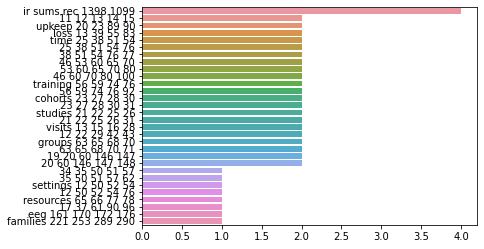

In [41]:
#plot_selected_top_ngrams_barchart(merged_df['normalized_tokens'], n=5, topcount = 30)
plot_selected_top_ngrams_barchart(my_doc, n=5, topcount = 30)

### 4.4 Further cleaning the text

In [12]:
# remove symbols, >,<,:,....

import re

# Function to clean text
def clean_text(text):
    # Ensure text is a string
    text = str(text)
    # Convert to lowercase
    text = text.lower()

    # Remove URLs
    text = re.sub(r'(https?://\S+|www\.\S+)', '', text)
    
    # Remove symbols
    symbols = ['\?', '\?\?', '>', '<', ';', ':', '<>']
    for symbol in symbols:
        text = re.sub(r'['+symbol+']', '', text)
    
    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply the cleaning function to the DataFrame
merged_df['cleaned_text'] = merged_df['text'].apply(clean_text)



In [14]:
print(merged_df[['text', 'cleaned_text']])

                                                    text  \
0      is growing rapidly and is expected to grow at ...   
1      a community owned , not for profit organisatio...   
2      Clinicians call for government to improve broa...   
3      Market Segment by Regions , this report splits...   
4      Market Study on Expected Growth for Critical C...   
...                                                  ...   
25589  As overthecounter hearing aids gain traction i...   
25590  Technology and data can improve SA healthcare ...   
25591  Dr Razi said : " Sehat Kahani is an incredible...   
25592  Georgie allows specialists in the Groote Schuu...   
25593  Telco sector policy wins and losses for 2023 D...   

                                            cleaned_text  
0      is growing rapidly and is expected to grow at ...  
1      a community owned , not for profit organisatio...  
2      clinicians call for government to improve broa...  
3      market segment by regions , this rep

### 4. NER

In [16]:
def process_text(item, max_length=1000000):
    # Check the length of the item
    if len(item) <= max_length:
        return nlp(item)
    else:
        # Handle long texts, e.g., by truncating or splitting
        # Here's a simple truncation example
        return nlp(item[:max_length])

dat_corpus = merged_df['cleaned_text'].dropna()
dat_test = [process_text(item) for item in dat_corpus]



In [17]:
def remove_ner(text):
    doc = nlp(text)
    newString = text
    for e in reversed(doc.ents):
        #if e.label_ == "PERSON": # Only if the entity is a PERSON
        if e.label_ in ["PERSON", "DATE", "TIME",'PERCENT','QUANTITY'] :
            newString = newString[:e.start_char] + newString[e.start_char + len(e.text):]
    return newString

In [18]:
## NER find names and remove from each doc
my_doc_ner = [remove_ner(str(my_doc))  for my_doc in dat_test]

In [27]:
my_doc_ner[1]

"a community owned , not for profit organisation offering quality care and lifestyle support for older australians since  . feros care 's mission is to be a strong ambassador and partner in the lives of seniors , with a focus on creating a range of lifestyle options that support independence , social connectedness and healthy ageing . feros care has a proven track record in pioneering new services and ensuring that all care and service packages are reliable , flexible , affordable and designed to meet individual needs . feros care has been recognised with national and international awards for innovations in care models , technology , positive living , culture and leadership . feros care operates feros village byron bay ( 40 low care beds ) , feros village bangalow ( 64 high care beds ) and feros village wommin bay ( 70 low and high care beds ) . in  , feros began offering extra services in an exclusive 16 bed cottage on the grounds of feros village bangalow . respite options include re

In [19]:
type(my_doc_ner[1])

str

In [22]:
from collections import Counter
def plot_named_entity_barchart(text):
    #nlp = spacy.load("en_core_web_sm")
    def _get_ner(text):
        doc=nlp(text)
        return [X.label_ for X in doc.ents]
    
    ent=[_get_ner(str(my_doc)) for my_doc in text]
    ent=[x for sub in ent for x in sub]
    counter=Counter(ent)
    count=counter.most_common()
    
    x,y=map(list,zip(*count))
    sns.barplot(x=y,y=x)

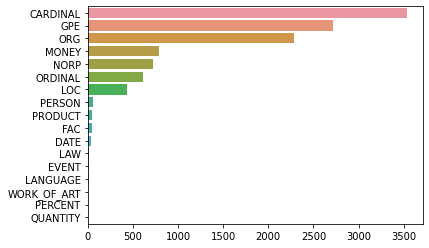

In [28]:
plot_named_entity_barchart(my_doc_ner[:500])

In [ ]:
plot_named_entity_barchart(my_doc_ner[:5000])

In [35]:
my_doc= pd.Series(my_doc_ner)

### 4.4 Spacy tokenized

In [ ]:
def tokenize_text(text, chunk_size=2500):
    """
    Tokenize text using Spacy, processing in chunks.
    """
    tokens = []
    for i in range(0, len(text), chunk_size):
        doc = nlp(text[i:i + chunk_size], disable=["parser", "ner"])
        tokens.extend([token.text for token in doc if not token.is_punct])
    return tokens

# Apply the function to each row in your DataFrame
merged_df['tokenized_text'] = merged_df['text'].apply(tokenize_text)


In [ ]:
# 1
countsDict = {}
for word in merged_df['tokenized_text'].sum():
    if word in countsDict:
        countsDict[word] += 1
    else:
        countsDict[word] = 1
word_counts = sorted(countsDict.items(), key = lambda x : x[1], reverse = True)

In [ ]:
word_counts[:30]

In [ ]:
# 2
#The stop list is then all words that occur before the first noun
stop_words_freq = []
for word, count in word_counts:
    if word == 'health':
        break
    else:
        stop_words_freq.append(word)
stop_words_freq

In [ ]:
# 3
merged_df['normalized_tokens'] = merged_df['tokenized_text'].apply(lambda x: normalizeTokens(x))

merged_df['normalized_tokens_count'] = merged_df['normalized_tokens'].apply(lambda x: len(x))

In [ ]:
#4. freq dist
#.sum() adds together the lists from each row into a single list
healthcfdist = nltk.ConditionalFreqDist(((len(w), w) for w in merged_df['normalized_tokens'].sum()))

#print the number of words
print(healthcfdist.N())

In [ ]:
# Check the number of conditions in the frequency distribution
print(len(healthcfdist.conditions()))

# print a sample of the frequency distribution
for condition in healthcfdist.conditions()[:5]:
    print(condition, healthcfdist[condition])

In [ ]:
healthcfdist[1].plot()

In [ ]:
# 5. Conditional Prob Dist
# This does not work for my data because we can see that 
# the lack of data in conditions 2,3,4,5 is expected due to the nature of the dataset (i.e., it's sparse)
#healthcpdist = nltk.ConditionalProbDist(healthcfdist, nltk.ELEProbDist)

# #print the most common 2 letter word
# print(healthcpdist[1].max())

# #And its probability
# print(healthcpdist[1].prob(healthcpdist[1].max()))

In [ ]:
merged_df['normalized_tokens_POS'] = [spacy_pos(t) for t in merged_df['text']]

In [13]:
#merged_df.to_csv('final_df_withtoken.csv',index=False)
merged_df=pd.read_csv("D:/NOW/output_files/final_df_withtoken.csv")

In [14]:
merged_df.head()

,textID,text,#words,date,country,website,url,title,year,tokenized_text,normalized_tokens,normalized_tokens_count,normalized_tokens_POS
0,16223152,is growing rapidly and is expected to grow at ...,333.0,17-01-04,AU,NewsMake,http://www.newsmaker.com.au/news/210232/digita...,Digital Pathology Market Key Players Q2 Soluti...,17.0,"['is', 'growing', 'rapidly', 'and', 'is', 'exp...","['grow', 'rapidly', 'expect', 'grow', 'cagr', ...",183,"[('is', 'VBZ'), ('growing', 'VBG'), ('rapidly'..."
1,16233365,"a community owned , not for profit organisatio...",458.0,17-01-04,AU,PRWir,http://prwire.com.au/pr/64982/make-2017-your-y...,Make 2017 your year to get a little bit of hel...,17.0,"['a', 'community', 'owned', 'not', 'for', 'pro...","['community', 'own', 'profit', 'organisation',...",249,"[('a', 'DT'), ('community', 'NN'), ('owned', '..."
2,16336940,Clinicians call for government to improve broa...,539.0,17-01-10,AU,CIO Australia,http://www.cio.com.au/article/612580/clinician...,Clinicians call for government to improve broa...,17.0,"['Clinicians', 'call', 'for', 'government', 't...","['clinician', 'government', 'improve', 'broadb...",279,"[('clinicians', 'NNS'), ('call', 'VBP'), ('for..."
3,16457068,"Market Segment by Regions , this report splits...",336.0,17-01-18,AU,NewsMake,http://www.newsmaker.com.au/news/224423/global...,"Global Healthcare IT Solutions Market Growth, ...",17.0,"['Market', 'Segment', 'by', 'Regions', 'this',...","['market', 'segment', 'region', 'report', 'spl...",209,"[('market', 'NN'), ('segment', 'NN'), ('by', '..."
4,16497238,Market Study on Expected Growth for Critical C...,719.0,17-01-20,AU,NewsMake,http://www.newsmaker.com.au/news/227591/market...,Market Study on Expected Growth for Critical C...,17.0,"['Market', 'Study', 'on', 'Expected', 'Growth'...","['market', 'study', 'expect', 'growth', 'criti...",419,"[('market', 'NN'), ('study', 'NN'), ('on', 'IN..."


In [18]:
merged_df['normalized_tokens']

0        ['grow', 'rapidly', 'expect', 'grow', 'cagr', ...
1        ['community', 'own', 'profit', 'organisation',...
2        ['clinician', 'government', 'improve', 'broadb...
3        ['market', 'segment', 'region', 'report', 'spl...
4        ['market', 'study', 'expect', 'growth', 'criti...
                               ...                        
25589    ['overthecounter', 'hearing', 'aid', 'gain', '...
25590    ['technology', 'datum', 'improve', 'sa', 'heal...
25591    ['dr', 'razi', 'say', 'sehat', 'kahani', 'incr...
25592    ['georgie', 'allow', 'specialist', 'groote', '...
25593    ['telco', 'sector', 'policy', 'win', 'loss', '...
Name: normalized_tokens, Length: 25594, dtype: object

In [15]:
# 'normalized_tokens_POS' contains POS-tagged tokens
# Example of expected format: [('NN', ''), ('VB', 'run'), ...]
merged_df['normalized_tokens_POS'][0]

"[('is', 'VBZ'), ('growing', 'VBG'), ('rapidly', 'RB'), ('and', 'CC'), ('is', 'VBZ'), ('expected', 'VBN'), ('to', 'TO'), ('grow', 'VB'), ('at', 'IN'), ('the', 'DT'), ('cagr', 'NN'), ('of', 'IN'), ('11.9', 'CD'), ('%', 'NN'), ('by', 'IN'), ('the', 'DT'), ('end', 'NN'), ('of', 'IN'), ('2022', 'CD'), (';', ':'), ('digital', 'JJ'), ('pathology', 'NN'), ('market', 'NN'), ('is', 'VBZ'), ('growing', 'VBG'), ('rapidly', 'RB'), ('and', 'CC'), ('expected', 'VBN'), ('to', 'TO'), ('reach', 'VB'), ('usd', 'NN'), ('700', 'CD'), ('million', 'CD'), ('by', 'IN'), ('the', 'DT'), ('end', 'NN'), ('of', 'IN'), ('2022', 'CD'), ('the', 'DT'), ('global', 'JJ'), ('digital', 'JJ'), ('pathology', 'NN'), ('market', 'NN'), ('has', 'VBZ'), ('been', 'VBN'), ('evaluated', 'VBN'), ('as', 'IN'), ('rapidly', 'RB'), ('growing', 'VBG'), ('market', 'NN'), ('and', 'CC'), ('expected', 'VBD'), ('that', 'IN'), ('the', 'DT'), ('market', 'NN'), ('will', 'MD'), ('reach', 'VB'), ('high', 'JJ'), ('growth', 'NN'), ('figures', 'NNS')

In [ ]:
# Print the first few rows of the 'normalized_tokens_POS' column
print(merged_df['normalized_tokens_POS'].head())

# Inspect the first row in detail
first_row = merged_df['normalized_tokens_POS'].iloc[0]
print(first_row)
print("Type of first row:", type(first_row))
print("Type of first element in the first row:", type(first_row[0]) if len(first_row) > 0 else "Empty")

import ast

# Function to convert a string representation of a list of tuples into an actual list of tuples
def convert_to_tuples(row):
    try:
        return ast.literal_eval(row)
    except:
        return []

# Apply the conversion function to the 'normalized_tokens_POS' column
merged_df['normalized_tokens_POS'] = merged_df['normalized_tokens_POS'].apply(convert_to_tuples)

# Check the type of the first element in the first row after conversion
if len(merged_df['normalized_tokens_POS'].iloc[0]) > 0:
    first_element_type = type(merged_df['normalized_tokens_POS'].iloc[0][0])
else:
    first_element_type = "Empty"

print("Type of first element in the first row after conversion:", first_element_type)


In [ ]:
#6.

# Flatten the list of lists (if necessary) and prepare it for ConditionalFreqDist
#cond_samples = [(tag, word) for sublist in merged_df['normalized_tokens_POS'] for (word, tag) in sublist]

# Each item in the list should be a tuple of two elements
healthcfdist_WordtoPOS = nltk.ConditionalFreqDist(merged_df['normalized_tokens_POS'].sum())
list(healthcfdist_WordtoPOS.items())[:10]


In [ ]:
healthcfdist_POStoWord = nltk.ConditionalFreqDist((p, w) for w, p in merged_df['normalized_tokens_POS'].sum())

In [ ]:
healthcfdist_POStoWord['JJ']

In [ ]:
healthcfdist_POStoWord['NN'].most_common(5)